# Convolutional Neural Networks on Three SET Classes
---
In this notebook, we train a **CNN** to classify a subset of our images from our SET training data. 

Our training data for this notebook are large color images that fall into one of 3 classes: 
* 1DGF - one diamond green full
* 1DGL - one diamond green lined
* 1DPF - one diamond purple full

<img src="misc_images/practice_set.jpg" width=200px style="transform:rotate(90deg)">

We have a total of 302 images with at least 100 images per class.

## Import packages

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms, models
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler

## Load the data

Load in the training data and split the training data into train, validation, and test sets. Resize our large images, which are 3456x4608x3, to 32x32x3 and normalize them for our model.

In [3]:
# check size of image in our dataset
im = Image.open('/Users/Sara/SETCardRecognition/training_data/1DGF/IMG_20190514_171439774.jpg')
print(im.size) # width, height

(3456, 4608)


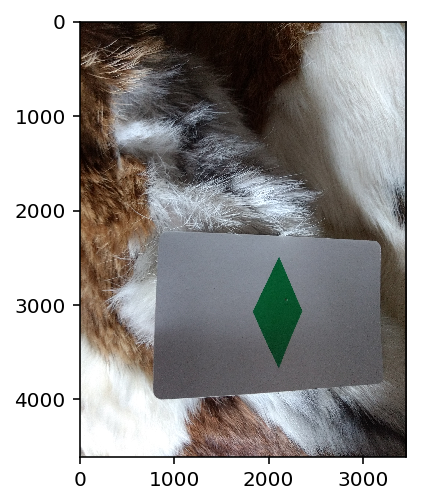

In [4]:
# view an image in our dataset
plt.imshow(im)

In [5]:
# folder containing training data
data_dir = '/Users/Sara/SETCardRecognition/data/practice_set/'

In [20]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 30
# percentage of dataset to use as validation
val_size = 0.1
# percentage of dataset to use as testing
test_size = 0.1

# create a transform to convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# apply the transform to the data
img_data = datasets.ImageFolder(data_dir, transform=transform)

# obtain data indices that will be used for training, testing, and validation
n = len(img_data) # total number of images
n_test = int(n * test_size) # number of images for test set
n_val = int(n * val_size) # number of images for validation set
n_train = n - n_test - n_val # number of images for training set
idx = list(range(n)) # indices to all images
np.random.shuffle(idx)
train_idx = idx[:n_train]
val_idx = idx[n_train:(n_train + n_val)]
test_idx = idx[(n_train + n_val):]

# define samplers for obtaining training, validation, and testing batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(img_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(img_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(img_data, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)

In [21]:
# classes in dataset
classes = train_loader.dataset.classes
print(classes)

['1DGF', '1DGL', '1DPF']


In [23]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

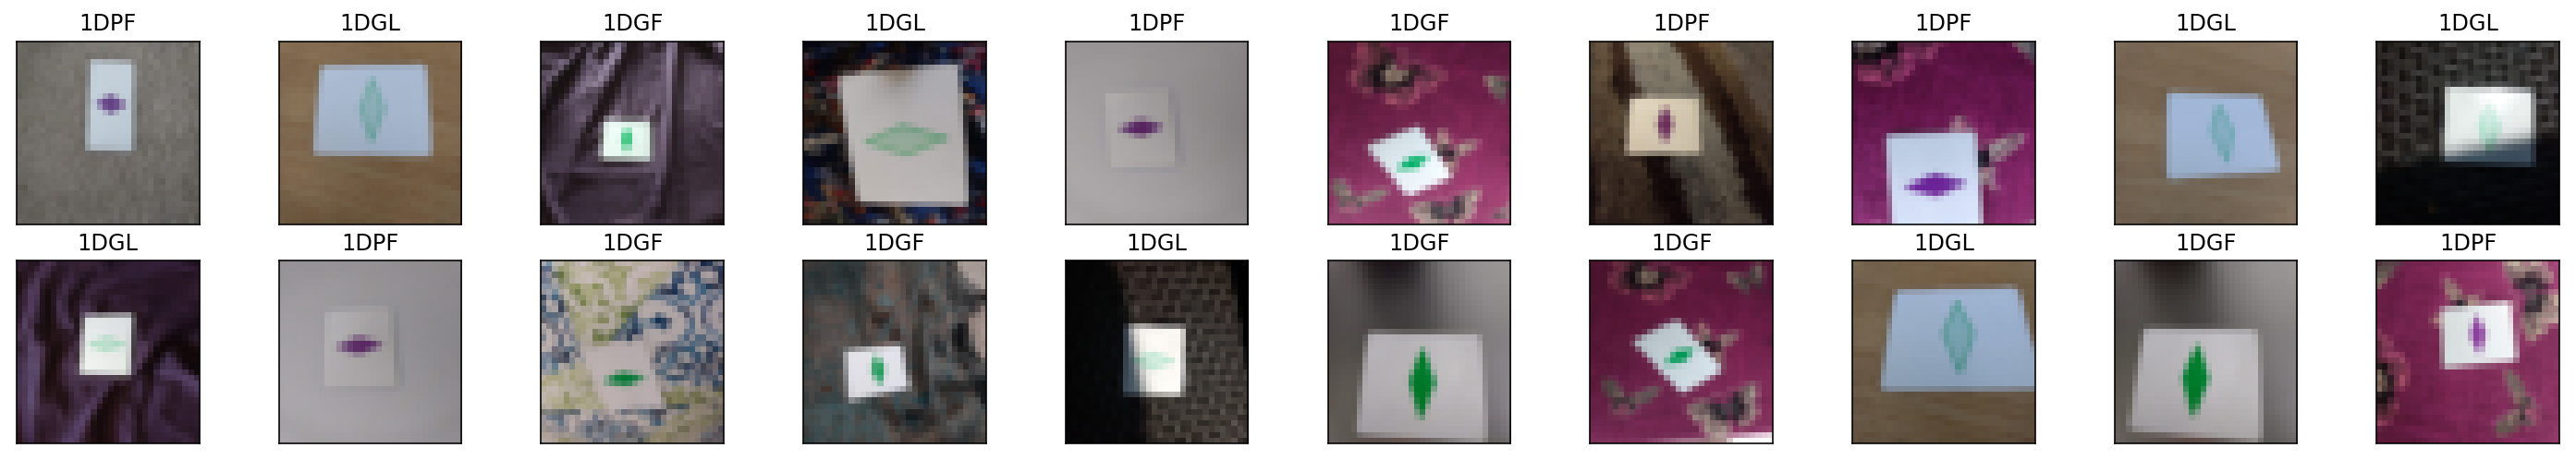

In [26]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_loader.dataset.classes[labels[idx]])

## Test for CUDA

Since these are larger (32x32x3) images, it may prove useful to speed up our training time by using a GPU with AWS. The following code will check if we have CUDA on our system. 

In [27]:
# check if CUDA is available
device = torch.cuda.is_available()

if not device:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Define the Network 

Our CNN architecture will have the following:

* Three __convolutional layers__ with 16, 32, and 64 filters respectively. Each filter has a kernel size of 3x3. 
* Three __maxpooling layers__ with a stride of 2 and a kernel size of 2x2.
* Two __fully connected layers__, including our output layer.
* ReLU activation and dropout rate set to 25% to prevent overfitting.

<img src="misc_images/cnn_3.png" width=550px>

This figure was generated by adapting code from https://github.com/gwding/draw_convnet.

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear output layer (500 -> 3)
        self.fc2 = nn.Linear(500, 3)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if device:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=3, bias=True)
  (dropout): Dropout(p=0.25)
)


### Specify Loss Function and Optimizer

In [29]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Train the Network

In [34]:
# number of epochs to train the model
n_epochs = 30

# track time to train model
start_time = time.time()

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if device:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if device:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_set_practice.pth')
        valid_loss_min = valid_loss
        
time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch: 1 	Training Loss: 0.881872 	Validation Loss: 0.109578
Validation loss decreased (inf --> 0.109578).  Saving model ...
Epoch: 2 	Training Loss: 0.877941 	Validation Loss: 0.108043
Validation loss decreased (0.109578 --> 0.108043).  Saving model ...
Epoch: 3 	Training Loss: 0.869550 	Validation Loss: 0.106366
Validation loss decreased (0.108043 --> 0.106366).  Saving model ...
Epoch: 4 	Training Loss: 0.845336 	Validation Loss: 0.111461
Epoch: 5 	Training Loss: 0.844184 	Validation Loss: 0.104119
Validation loss decreased (0.106366 --> 0.104119).  Saving model ...
Epoch: 6 	Training Loss: 0.845831 	Validation Loss: 0.104403
Epoch: 7 	Training Loss: 0.811164 	Validation Loss: 0.103410
Validation loss decreased (0.104119 --> 0.103410).  Saving model ...
Epoch: 8 	Training Loss: 0.772521 	Validation Loss: 0.103980
Epoch: 9 	Training Loss: 0.725690 	Validation Loss: 0.104444
Epoch: 10 	Training Loss: 0.711094 	Validation Loss: 0.114789
Epoch: 11 	Training Loss: 0.726693 	Validation Lo

### Load the Model with the Lowest Validation Loss

In [35]:
model.load_state_dict(torch.load('model_set_practice.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Test the Trained Network

In [36]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if device:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.020640

Test Accuracy of  1DGF: 100% ( 7/ 7)
Test Accuracy of  1DGL: 85% (12/14)
Test Accuracy of  1DPF: 100% ( 9/ 9)

Test Accuracy (Overall): 93% (28/30)


### Visualize Sample Test Results

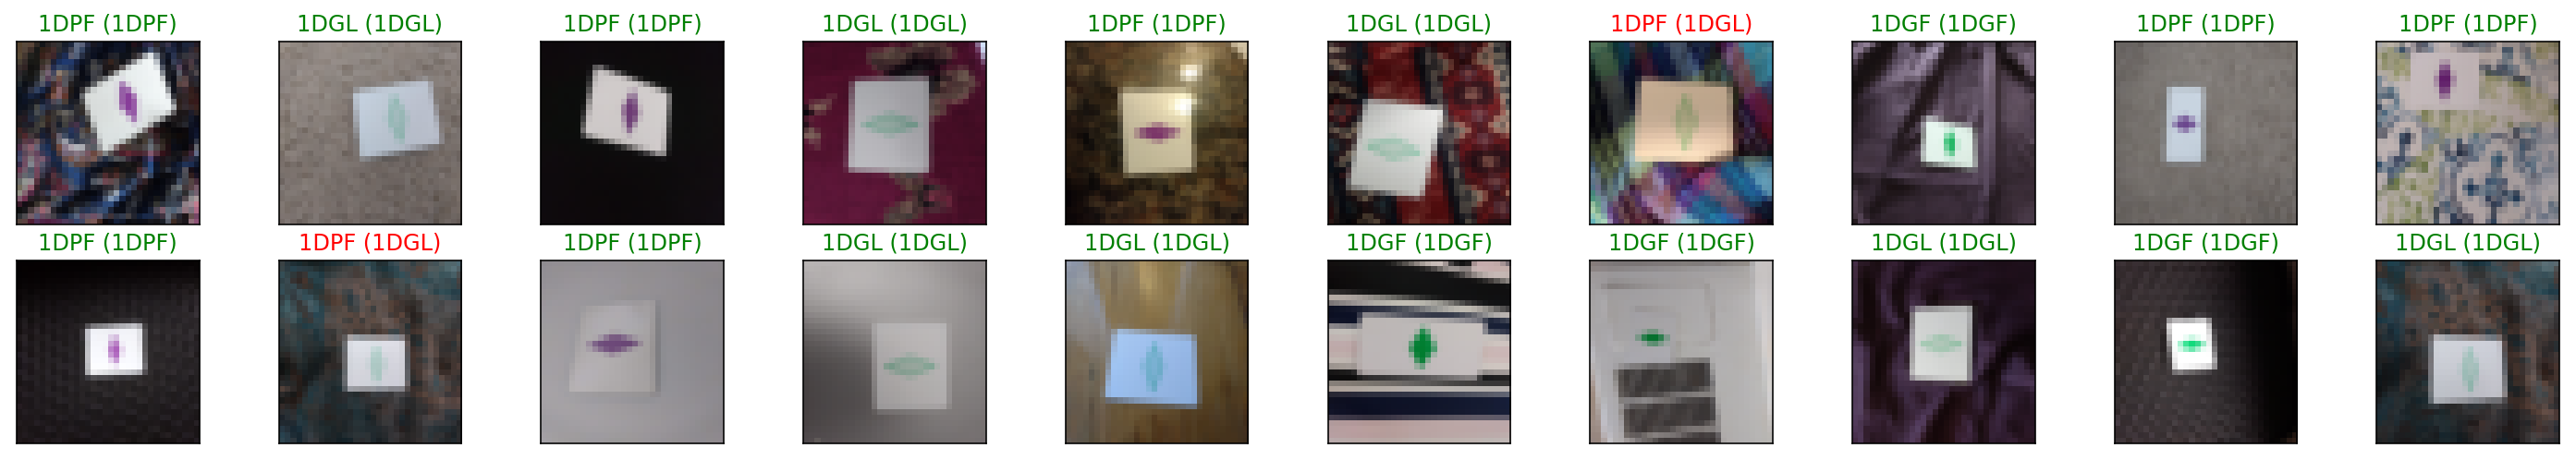

In [37]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if device:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not device else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## Summary

Our CNN model achieved 93% (28/30) accuracy with our test set. It accurately classified all the cards in two of the three classes. However, the model only classified 85% (12/14) of the cards in 1DGL (one diamond green lined) correctly. As shown in the visualization above, the two cards were misclassified as 1DPF (one diamond purple full). It's possible that if we trained the model longer, we could have achieved 100% accuracy since the training loss appears to still be decreasing at epoch 30.